# Cassava Lead Disease Classification 

Kaggle Link : https://www.kaggle.com/c/cassava-leaf-disease-classification/overview

I went on with a smaller model `resnet18` and tried to increase the number of epochs this time. Things worked really well and the valid and train set weren't overfitting. The model was able to get approx 86% with **20 epochs**, maybe in future will train for more than 20 epochs. 

I got issues on submitting my results / outputs on Kaggle gotta fix it. 

In [ ]:
from fastai.vision.all import * 
from fastai import * 
import pandas as pd 
import numpy as np

In [2]:
train_data = Path('train_images/')
test_data = Path('test_images/')


In [3]:
# Getting the labels 

df = pd.read_csv('train.csv')
df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [4]:
rename = {
    0: "Cassava Bacterial Blight (CBB)" , 
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy",
}

# Mapping the numbers into string 

df['label'] = df['label'].apply(lambda x: rename[x])
df


,image_id,label
0,1000015157.jpg,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,Cassava Mosaic Disease (CMD)
2,100042118.jpg,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,Cassava Mosaic Disease (CMD)
...,...,...
21392,999068805.jpg,Cassava Mosaic Disease (CMD)
21393,999329392.jpg,Cassava Mosaic Disease (CMD)
21394,999474432.jpg,Cassava Brown Streak Disease (CBSD)
21395,999616605.jpg,Healthy


In [5]:
# Getting the filenames 

fns_train = get_image_files(train_data)
fns_test = get_image_files(test_data)

len(fns_train) , len(fns_test)

(21397, 1)

In [6]:
fns_train

(#21397) [Path('train_images/1909072265.jpg'),Path('train_images/2484133186.jpg'),Path('train_images/113596289.jpg'),Path('train_images/2633910453.jpg'),Path('train_images/3902577668.jpg'),Path('train_images/1835807693.jpg'),Path('train_images/901886086.jpg'),Path('train_images/628791743.jpg'),Path('train_images/1924914.jpg'),Path('train_images/3421593064.jpg')...]

In [7]:
# Transforms 

item_tfms = RandomResizedCrop(460, min_scale=0.75),
batch_tfms = [*aug_transforms(size=224, max_warp=0 , max_zoom= 0.8 ), Normalize.from_stats(*imagenet_stats)]

In [8]:
# Building a DataBlock 


cassava = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader(0, pref=f'train_images/'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1),
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms ) 

In [9]:
cassava.summary(df)

Setting-up type transforms pipelines
0      1000015157.jpg       Cassava Bacterial Blight (CBB)
1      1000201771.jpg         Cassava Mosaic Disease (CMD)
2       100042118.jpg  Cassava Brown Streak Disease (CBSD)
3      1000723321.jpg  Cassava Brown Streak Disease (CBSD)
4      1000812911.jpg         Cassava Mosaic Disease (CMD)
...               ...                                  ...
21392   999068805.jpg         Cassava Mosaic Disease (CMD)
21393   999329392.jpg         Cassava Mosaic Disease (CMD)
21394   999474432.jpg  Cassava Brown Streak Disease (CBSD)
21395   999616605.jpg                              Healthy
21396   999998473.jpg                              Healthy

[21397 rows x 2 columns]
Found 21397 items
2 datasets of sizes 17118,4279
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': 'train_images/', 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab':

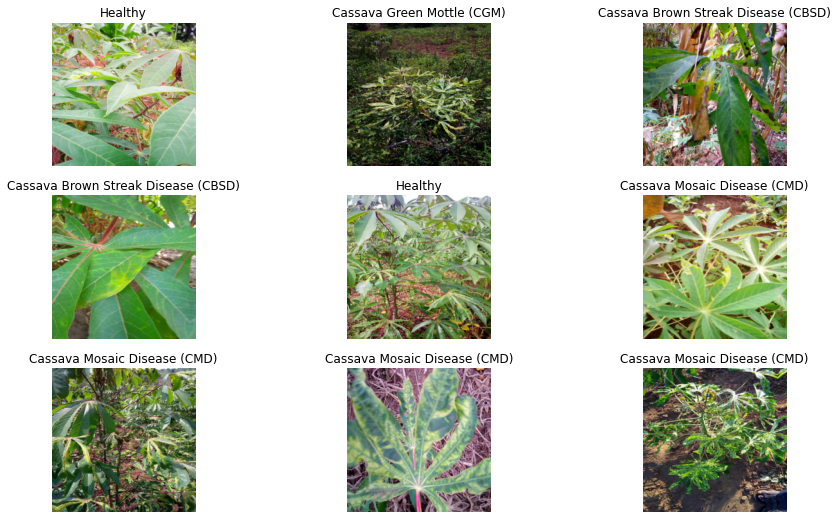

In [10]:
# Putting into a dataloader 

train_dls = cassava.dataloaders(df , bs = 32)
train_dls.show_batch(figsize = (15 , 9))

In [ ]:
loss_func = CrossEntropyLossFlat()

In [11]:
# Creating a learner 

learn = cnn_learner(train_dls , resnet18 , metrics = [error_rate , accuracy] , pretrained = True )

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=7.585775847473997e-07)

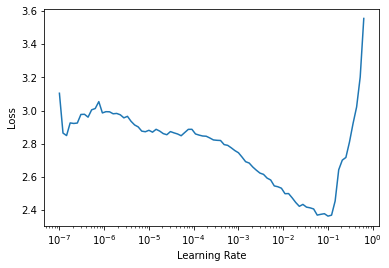

In [12]:
# Finding the learning rate / freezed 

learn.lr_find()

In [13]:
# Training for 3 epochs 

learn.fit_one_cycle(3 , 3e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.197870,0.874572,0.288619,0.711381,02:18
1,0.960664,0.717285,0.254732,0.745268,02:18
2,0.883049,0.697365,0.246086,0.753914,02:16


In [14]:
# Unfreezing all the networks 

learn.unfreeze()

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=7.585775847473997e-07)

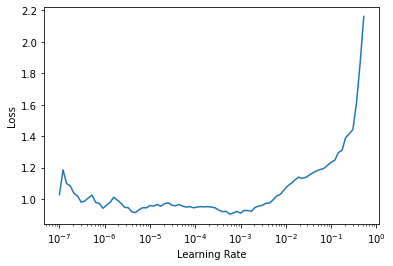

In [15]:
# Again the lr 

learn.lr_find()

In [17]:
# Training the whole network 

learn.fit_one_cycle(20 , lr_max = slice(4e-3 , 1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.805999,0.745131,0.244216,0.755784,02:49
1,0.852131,1.028395,0.343305,0.656695,02:48
2,0.883441,0.870213,0.315962,0.684038,02:48
3,0.798622,0.807814,0.320168,0.679832,02:45
4,0.801675,1.531570,0.657397,0.342603,02:44
5,0.699348,0.710793,0.274831,0.725169,02:52
6,0.707193,0.677050,0.248189,0.751811,02:47
7,0.698767,0.652497,0.247488,0.752512,02:57
8,0.643363,0.603968,0.225754,0.774246,02:46
9,0.593718,0.561968,0.205188,0.794812,02:46


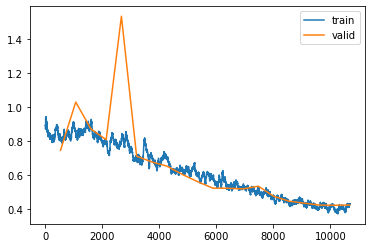

In [18]:
# Plotting the loss 

learn.recorder.plot_loss()

In [19]:
# Creating a test dataloader 

test_dl = train_dls.test_dl(fns_test)

# Getting the predictions for the test set 

test_pred = learn.get_preds(dl = test_dl)
test_pred

(TensorImage([[0.0081, 0.0038, 0.6370, 0.1896, 0.1616]]), None)

In [20]:
# Getting in the Sample Submission File 
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub

,image_id,label
0,2216849948.jpg,4


In [21]:
test_pred_max = test_pred[0].argmax(dim=1)
pred_labels = [train_dls.vocab[o] for o in test_pred_max]
sub = pd.DataFrame({'Image_Id':test_dl.items,'label':pred_labels})
sub

,Image_Id,label
0,test_images/2216849948.jpg,Cassava Green Mottle (CGM)


In [22]:
sub['Image_Id'] = sub['Image_Id'].astype(str).str.replace('test_images/' , '')
sub

,Image_Id,label
0,2216849948.jpg,Cassava Green Mottle (CGM)


In [23]:
sub.to_csv('submission.csv' , index=False)